In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("../lib")
import segmentation as sg

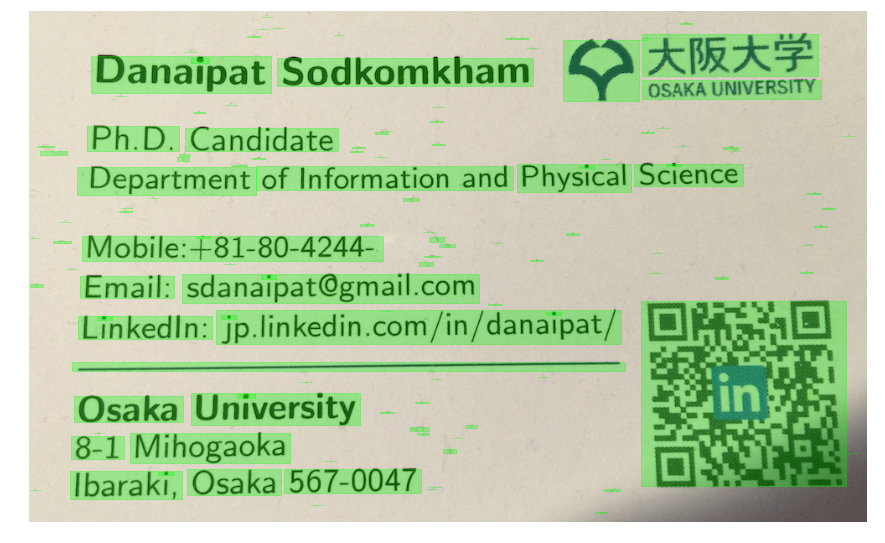

In [4]:
from skimage import io
reload(sg)
    
img = io.imread('../data/card.jpg')
text_segments = sg.text_segments(img)

plt.gcf().set_size_inches(15, 10)
plt.axis('off')
plt.imshow(img, cmap=plt.cm.gray)
ax = plt.gca()

for s in text_segments:
    ax.add_patch(matplotlib.patches.Rectangle((s[1], s[0]), s[3] - s[1], s[2] - s[0], color=(0, 1, 0, 0.3)))

In [3]:
def extract(img, segment):
    return img[segment[0]:segment[2], segment[1]:segment[3]]

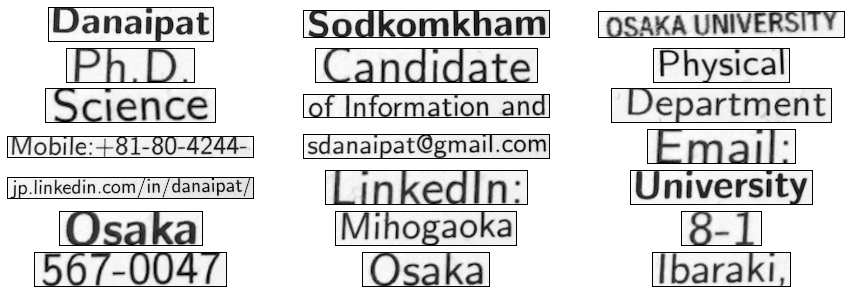

In [7]:
grayscale_img = sg.rgb2grayscale(img)
segments = [extract(grayscale_img, seg) for seg in text_segments]

plt.gcf().set_size_inches(15, 5)
for i, s in enumerate(segments):
    plt.subplot(len(segments)/3, 3, i + 1)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.imshow(s, cmap=plt.cm.gray)

In [36]:
# generate artificial training data
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import string
import random


characters = string.ascii_letters + string.digits
font_path = "/Library/Fonts/"
font_choices = ["Arial.ttf",
                "Arial Black.ttf",
                "Arial Bold Italic.ttf",
                "Arial Bold.ttf",
                "Arial Italic.ttf",
                "Arial Narrow Bold Italic.ttf",
                "Arial Narrow Bold.ttf",
                "Arial Narrow Italic.ttf",
                "Arial Narrow.ttf",
                "Arial Rounded Bold.ttf",
                "Arial Unicode.ttf"]

W = 28
H = 24    

i = 0
for _ in range(3):
    for c1 in characters:
        for c2 in characters:
            cl = random.choice(characters)
            cr = random.choice(characters)
            img = Image.new("L", (W, H), 255 - random.randint(0, 50))
            draw = ImageDraw.Draw(img)
            font_name = random.choice(font_choices)
            font = ImageFont.truetype(font_path+font_name, 24 + random.randint(-2, 0))
            w1, h1 = draw.textsize(cl + c1, font=font)
            w2, h2 = draw.textsize(c2 + cr, font=font)
            w, h = draw.textsize(cl + c1 + c2 + cr, font=font)
            mid = (w1 + (w - w1 - w2)/2)
            draw.text((-(mid - W/2), -(H-h)/2), cl + c1 + c2 + cr, random.randint(0, 50), font=font)
            img.save("../data/character_segmentation2/pos/%d.png" % i)
            i += 1
            

In [35]:
# generate artificial training data

i = 0
for _ in range(3):
    for c1 in characters:
        for c2 in characters:
            cl = random.choice(characters)
            cr = random.choice(characters)
            img = Image.new("L", (W, H), 255 - random.randint(0, 50))
            draw = ImageDraw.Draw(img)
            font_name = random.choice(font_choices)
            font = ImageFont.truetype(font_path+font_name, 24 + random.randint(-2, 0))
            w1, _ = draw.textsize(cl + c1, font=font)
            w2, _ = draw.textsize(c2 + cr, font=font)
            w, h = draw.textsize(cl + c1 + c2 + cr, font=font)
            mid = (w1 + (w - w1 - w2)/2)
            draw.text((-(mid - W/2) + random.choice([-4, -3, 3, 4]), -(H-h)/2), cl + c1 + c2 + cr, random.randint(0, 50), font=font)
            img.save("../data/character_segmentation2/neg/%d.png" % i)
            i += 1

for _ in range(4000/len(characters)):
    for c in characters:
        cl = random.choice(characters)
        cr = random.choice(characters)
        img = Image.new("L", (W, H), 255 - random.randint(0, 50))
        draw = ImageDraw.Draw(img)
        font_name = random.choice(font_choices)
        font = ImageFont.truetype(font_path+font_name, 24 + random.randint(-2, 0))
        w1, _ = draw.textsize(cl, font=font)
        w2, _ = draw.textsize(cr, font=font)
        w, h = draw.textsize(cl + c + cr, font=font)
        mid = (w1 + (w - w1 - w2)/2)
        draw.text((-(mid - W/2), -(H-h)/2), cl + c + cr, random.randint(0, 50), font=font)
        img.save("../data/character_segmentation2/neg/%d.png" % i)
        i += 1


In [37]:
from skimage import io
import os

W = 28
H = 24 

path, dirs, files = os.walk("../data/character_segmentation2/pos").next()
N_pos = len(files)

path, dirs, files = os.walk("../data/character_segmentation2/neg").next()
N_neg = len(files)

pos = np.zeros((N_pos, H, W))
neg = np.zeros((N_neg, H, W))

for i in range(N_pos):
    pos[i] = io.imread("../data/character_segmentation2/pos/%d.png" % i)


for i in range(N_neg):
    neg[i] = io.imread("../data/character_segmentation2/neg/%d.png" % i)

print N_pos, N_neg

11532 15500


In [38]:
N = N_pos + N_neg
X = np.vstack((pos, neg)).reshape(N, W*H).astype(np.float32)
y = np.array([1] * N_pos + [0] * N_neg).astype(np.int32)

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [40]:
from lasagne.nonlinearities import softmax
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, H, W),
    conv1_num_filters=16, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2), dropout1_p=0.1,
    hidden4_num_units=256, dropout4_p=0.4,
    hidden5_num_units=256,
    output_num_units=2, 
    output_nonlinearity=softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    regression=False,
    max_epochs=1000,
    verbose=1,
    )

In [41]:
indexes = range(N)
np.random.shuffle(indexes)

net = net.fit(X.reshape(N, 1, H, W)[indexes], y[indexes])

  DenseLayer        	(None, 2)           	produces       2 outputs
  DenseLayer        	(None, 256)         	produces     256 outputs
  DropoutLayer      	(None, 256)         	produces     256 outputs
  DenseLayer        	(None, 256)         	produces     256 outputs
  DropoutLayer      	(None, 16, 11, 13)  	produces    2288 outputs
  MaxPool2DLayer    	(None, 16, 11, 13)  	produces    2288 outputs
  Conv2DLayer       	(None, 16, 22, 26)  	produces    9152 outputs
  InputLayer        	(None, 1, 24, 28)   	produces     672 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.657642  |    0.601060  |     1.094137  |     71.12%  |  19.1s
     2  |    0.585593  |    0.527121  |     1.110927  |     80.35%  |  37.5s
     3  |    0.519789  |    0.460730  |     1.128186  |     84.55%  |  32.5s
     4  |    0.462483  |    0.404416  |     1.143583  |     87.15%  |  30.0s
   

KeyboardInterrupt: 

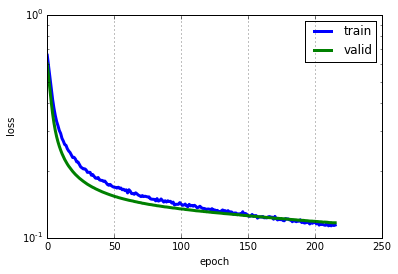

In [42]:
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.yscale("log")
pyplot.show()

In [43]:
import cPickle as pickle
with open('net-conv.pickle', 'wb') as f:
    pickle.dump(net, f, -1)

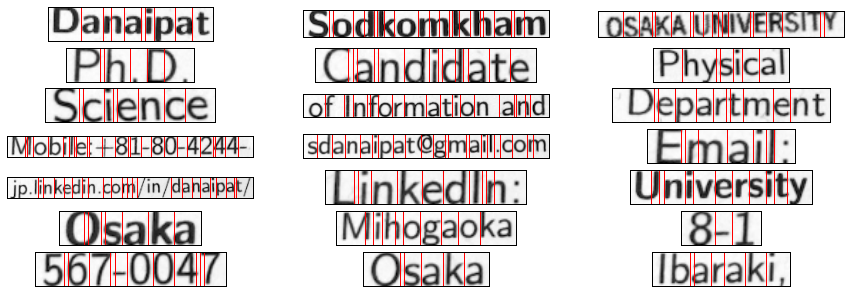

In [45]:
from skimage.transform import resize

plt.gcf().set_size_inches(15, 5)
for i, s in enumerate(segments):
    plt.subplot(len(segments)/3, 3, i + 1)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    ratio = 1. * s.shape[0] / s.shape[1]
    im = resize(s.astype(np.float64), (H, int(H / ratio)))
    cut_pts = []

    for i in range(0, im.shape[1] - W, 3):
        x = scaler.transform(im[:, i:i+W].reshape(1, -1))
        cut = net.predict(x.reshape(1, 1, H, W))
        if cut:
            cut_pts.append(i + W/2)
            
    plt.imshow(im, cmap=plt.cm.gray)
    for c in cut_pts:
        plt.axvline(c, 0, 22, c='r')

In [ ]:
test